In [1]:
import tfim
import tfim_perturbation
import numpy as np
from scipy import sparse
from scipy.sparse import linalg as spla
from scipy import linalg
import matplotlib.pyplot as plt
from scipy import optimize
import progressbar

In [2]:
# Initial system specification
L = [8]
Jij_seed = 9
h_x_range = np.arange(0, 0.1, 0.002)

In [3]:
PBC = True
J = 1

In [4]:
# Build lattice and basis
###################################
lattice = tfim.Lattice(L, PBC)
N = lattice.N
basis = tfim.IsingBasis(lattice)
###################################

#construct random J matrix
Jij = tfim.Jij_instance(N,J,"bimodal",Jij_seed) 

In [5]:
# List out all the spin_states, corresponding indices and energies
Energies = -tfim.JZZ_SK_ME(basis,Jij)
for index in range(2**N):
    print index, basis.state(index), Energies[index]

100% |########################################################################|


0 [0 0 0 0 0 0 0 0] -0.0
1 [0 0 0 0 0 0 0 1] -2.0
2 [0 0 0 0 0 0 1 0] 6.0
3 [0 0 0 0 0 0 1 1] -0.0
4 [0 0 0 0 0 1 0 0] 2.0
5 [0 0 0 0 0 1 0 1] 4.0
6 [0 0 0 0 0 1 1 0] 4.0
7 [0 0 0 0 0 1 1 1] 2.0
8 [0 0 0 0 1 0 0 0] -2.0
9 [0 0 0 0 1 0 0 1] -0.0
10 [0 0 0 0 1 0 1 0] -0.0
11 [0 0 0 0 1 0 1 1] -2.0
12 [0 0 0 0 1 1 0 0] 4.0
13 [0 0 0 0 1 1 0 1] 10.0
14 [0 0 0 0 1 1 1 0] 2.0
15 [0 0 0 0 1 1 1 1] 4.0
16 [0 0 0 1 0 0 0 0] -2.0
17 [0 0 0 1 0 0 0 1] -8.0
18 [0 0 0 1 0 0 1 0] -0.0
19 [0 0 0 1 0 0 1 1] -10.0
20 [0 0 0 1 0 1 0 0] 4.0
21 [0 0 0 1 0 1 0 1] 2.0
22 [0 0 0 1 0 1 1 0] 2.0
23 [0 0 0 1 0 1 1 1] -4.0
24 [0 0 0 1 1 0 0 0] -0.0
25 [0 0 0 1 1 0 0 1] -2.0
26 [0 0 0 1 1 0 1 0] -2.0
27 [0 0 0 1 1 0 1 1] -8.0
28 [0 0 0 1 1 1 0 0] 10.0
29 [0 0 0 1 1 1 0 1] 12.0
30 [0 0 0 1 1 1 1 0] 4.0
31 [0 0 0 1 1 1 1 1] 2.0
32 [0 0 1 0 0 0 0 0] 6.0
33 [0 0 1 0 0 0 0 1] -0.0
34 [0 0 1 0 0 0 1 0] 8.0
35 [0 0 1 0 0 0 1 1] -2.0
36 [0 0 1 0 0 1 0 0] 4.0
37 [0 0 1 0 0 1 0 1] 2.0
38 [0 0 1 0 0 1 1 0] 2.0
39 [0 0 1 0 0

In [6]:
# Build 2nd order approximated matrix

GS_energy, GS_indices = tfim_perturbation.GS(Energies)

H_app_0 = tfim_perturbation.H_app_0(GS_energy, GS_indices)

H_app_1 = tfim_perturbation.H_app_1(basis, GS_indices, N)

H_app_2 = tfim_perturbation.H_app_2(basis, Jij, GS_indices, N, GS_energy)

print GS_indices

[ 19  59 100 103 110 145 152 155 196 236]


In [7]:
# Build exact matrix
V_exc = tfim_perturbation.V_exact(basis, lattice)

H_0_exc = tfim_perturbation.H_0_exact(Energies)

In [8]:
# Calculate approximated eigenvalues and eigenstates for range(h_x)
app_eigenvalues, app_eigenstates = tfim_perturbation.app_eigensystem(GS_indices, GS_energy, h_x_range, J, N, basis, Jij)

In [9]:
# Calculate exact eigenvalues and eigenstates for range(h_x)
exc_eigenvalues, exc_eigenstates = tfim_perturbation.exc_eigensystem(basis, h_x_range, lattice, Energies)

In [10]:
reordered_app_eigenstates = np.zeros([len(h_x_range), len(GS_indices), len(GS_indices)])
epsilon = 1*10**(-6)

for h_x_index in range(len(h_x_range)):
    if h_x_index < 2:
        reordered_app_eigenstates[h_x_index] = app_eigenstates[h_x_index]
    else: 
        for k in range(len(GS_indices)/2):
            fidelity_array = []
            for v1 in [reordered_app_eigenstates[h_x_index-1, :, 2*k], reordered_app_eigenstates[h_x_index-1, :, 2*k+1]]:
                for v2 in [app_eigenstates[h_x_index, :, 2*k], app_eigenstates[h_x_index, :, 2*k+1]]:
                    fidelity_array = np.append(fidelity_array,tfim_perturbation.fidelity(v1,v2))
            if abs(fidelity_array[0] - max(fidelity_array)) < epsilon:
                reordered_app_eigenstates[h_x_index, :, 2*k] = app_eigenstates[h_x_index, :, 2*k]
                reordered_app_eigenstates[h_x_index, :, 2*k + 1] = app_eigenstates[h_x_index, :, 2*k + 1]
            else:
                reordered_app_eigenstates[h_x_index, :, 2*k] = app_eigenstates[h_x_index, :, 2*k + 1]
                reordered_app_eigenstates[h_x_index, :, 2*k + 1] = app_eigenstates[h_x_index, :, 2*k]

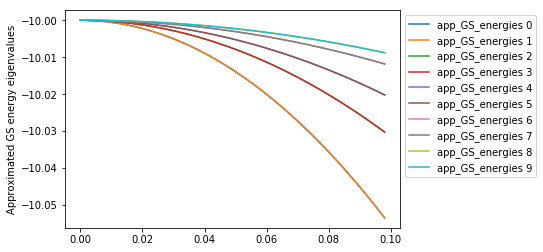

In [11]:
# Plot app GS energy vs h_x
for i in range(len(GS_indices)):
    app_GS_energy_plot = plt.plot(h_x_range, app_eigenvalues[i],label = 'app_GS_energies ' + str(i))
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)
plt.ylabel("Approximated GS energy eigenvalues")
plt.show(app_GS_energy_plot)

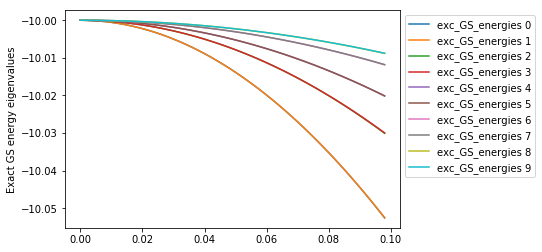

In [12]:
# Plot exc GS energy vs h_x
for i in range(len(GS_indices)):
    exc_GS_energy_plot = plt.plot(h_x_range, exc_eigenvalues[i], label = 'exc_GS_energies ' + str(i))
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)
plt.ylabel("Exact GS energy eigenvalues")
plt.show(exc_GS_energy_plot)

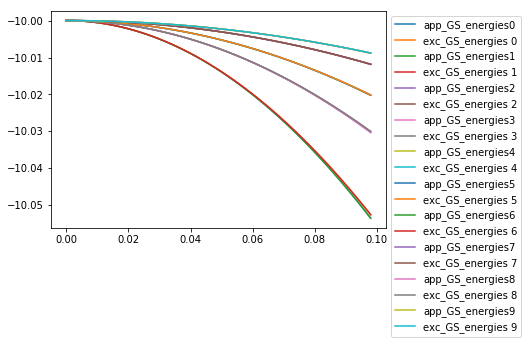

In [13]:
# Compare the exact and approximated GS energies

for i in range(len(GS_indices)):
    plt.plot(h_x_range, app_eigenvalues[i], label = 'app_GS_energies' + str(i))
    plt.plot(h_x_range, exc_eigenvalues[i],label = 'exc_GS_energies ' + str(i))
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)

[0.04381307 9.57301296]
[ 0.04640534 10.12935614]
[0.00452693 2.01641669]
[0.00786384 3.22281672]
[0.00113178 0.75131158]
[0.00102886 0.89704915]
[1.74547380e-04 2.61410207e-01]
[2.76867075e-04 3.21348724e-01]
[3.36224121e-05 1.34785221e-01]
[5.11860797e-05 7.99801779e-02]


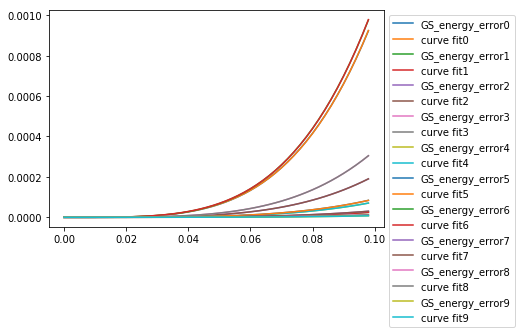

In [14]:
# Calculate and plot energy errors

corrected_exc_eigenvalues = np.zeros((len(GS_indices), len(h_x_range)))

for i in range(len(GS_indices)):
    for j in range(len(h_x_range)):
        corrected_exc_eigenvalues[i, j] = exc_eigenvalues[i, j]

error_array = np.absolute(corrected_exc_eigenvalues - app_eigenvalues)

# Curve fit

for i in range(len(GS_indices)):
    popt, pcov = optimize.curve_fit(tfim_perturbation.poly_4, h_x_range, error_array[i])
    print popt
    GS_energy_error_plot = plt.plot(h_x_range, error_array[i], label = 'GS_energy_error' + str(i))
    plt.plot(h_x_range, tfim_perturbation.poly_4(h_x_range, *popt), label = 'curve fit' + str(i))
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)

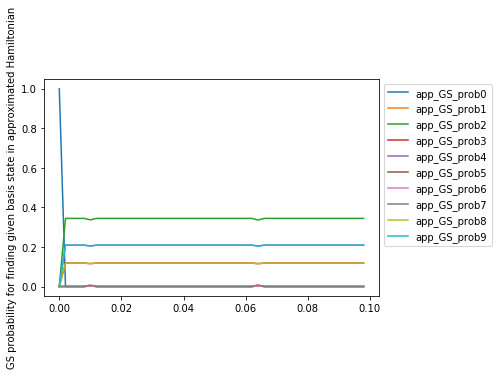

In [15]:
# Calculate probabilities for approximated eigenstates

prob_app = tfim_perturbation.prob_app(GS_indices, h_x_range, reordered_app_eigenstates)

# Plot probabilities for finding six bases states for system in ground eigenstate (approximated)

for i in range(len(GS_indices)):
    app_GS_probability_plot = plt.plot(h_x_range, prob_app[i], label = 'app_GS_prob' + str(i))
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)
plt.ylabel("GS probability for finding given basis state in approximated Hamiltonian")
plt.show(app_GS_probability_plot)

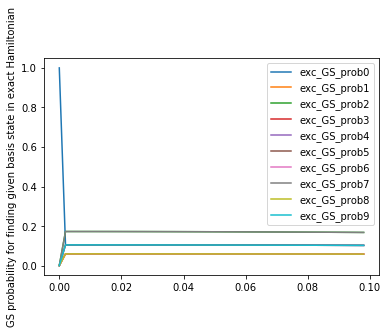

In [16]:
# Calculate probabilities for exact eigenstates

prob_exc = tfim_perturbation.prob_exc(GS_indices, h_x_range, exc_eigenstates)

# Plot probabilities for finding six bases states for system in ground eigenstate (exact)

for i in range(len(GS_indices)):
    exc_GS_probability_plot = plt.plot(h_x_range, prob_exc[i], label = 'exc_GS_prob' + str(i))
    plt.legend(loc = 'upper right', bbox_to_anchor=(1, 1), ncol = 1)
plt.ylabel("GS probability for finding given basis state in exact Hamiltonian")
plt.show(exc_GS_probability_plot)

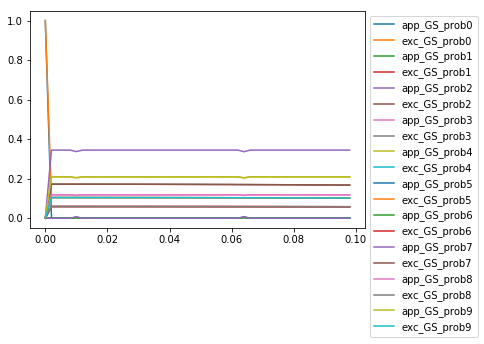

In [17]:
# Compare probabilities

for i in range(len(GS_indices)):
    app_GS_probability_plot = plt.plot(h_x_range, prob_app[i], label = 'app_GS_prob' + str(i))
    exc_GS_probability_plot = plt.plot(h_x_range, prob_exc[i], label = 'exc_GS_prob' + str(i))
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)

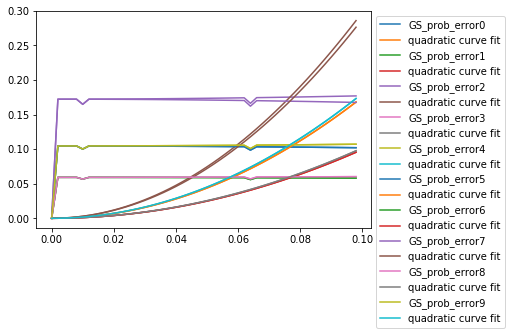

In [18]:
# Calculate and plot probability errors

prob_error_array = np.absolute(prob_app - prob_exc)

# Curve fit
for i in range(len(GS_indices)):
    popt, pcov = optimize.curve_fit(tfim_perturbation.poly_2, h_x_range, prob_error_array[i])
    GS_probability_error_plot = plt.plot(h_x_range, prob_error_array[i], label = 'GS_prob_error' + str(i))
    plt.plot(h_x_range, tfim_perturbation.poly_2(h_x_range, *popt), label = 'quadratic curve fit')
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)

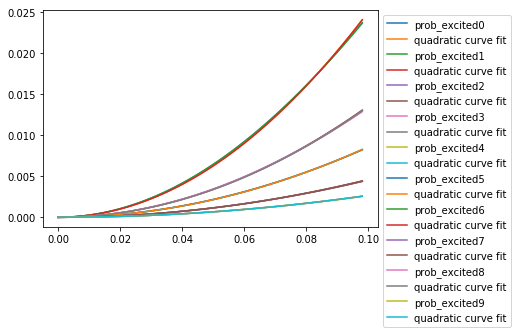

In [19]:
# Probability of finding the exact system to be in excited states
prob_exc_total = tfim_perturbation.prob_exc_total(GS_indices, h_x_range, exc_eigenstates)

prob_excited_sum = tfim_perturbation.prob_excited_sum(GS_indices, h_x_range, prob_exc_total)

for i in range(len(GS_indices)):
    popt, pcov = optimize.curve_fit(tfim_perturbation.poly_2, h_x_range, prob_excited_sum[i])
    plt.plot(h_x_range, prob_excited_sum[i], label = 'prob_excited' + str(i))
    plt.plot(h_x_range, tfim_perturbation.poly_2(h_x_range, *popt), label = 'quadratic curve fit')
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)

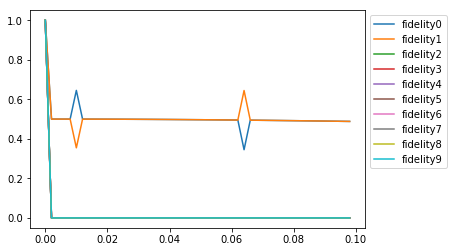

In [20]:
# Plot fidelity

# Extract ground states from exc_states matrix and renormalize
normalized_GS_exc_eigenstates = tfim_perturbation.norm_GS_exc_eigenstates(GS_indices, h_x_range, exc_eigenstates)

# Identify energy levels, sort, and calculate fidelity_array to be plotted
GS_exc_eigenvalues = exc_eigenvalues[0:len(GS_indices)]
fidelity_array = tfim_perturbation.fidelity_array(GS_indices, h_x_range, GS_exc_eigenvalues, app_eigenvalues, exc_eigenstates, app_eigenstates)

# Plot fidelity array
for i in range(len(GS_indices)):
    plt.plot(h_x_range, fidelity_array[i], label = 'fidelity' + str(i))
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)

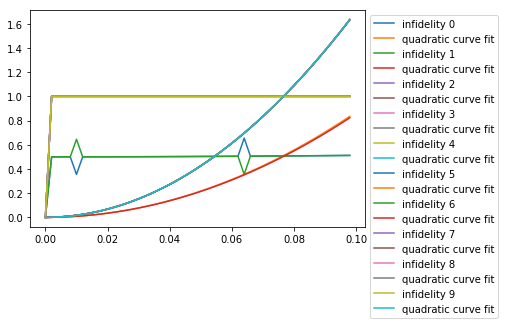

In [21]:
# Plot infidelity

infidelity_array = tfim_perturbation.infidelity_array(fidelity_array)

for i in range(len(GS_indices)):
    popt, pcov = optimize.curve_fit(tfim_perturbation.poly_2, h_x_range, infidelity_array[i])
    plt.plot(h_x_range, infidelity_array[i], label = 'infidelity ' + str(i))
    plt.plot(h_x_range, tfim_perturbation.poly_2(h_x_range, *popt), label = 'quadratic curve fit')
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)